# Modeling

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pypfopt
#
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [24]:
df_static = pd.read_csv('../../data/df_overview.csv', index_col=0)
df_time_series = pd.read_csv('../../data/df_monthly_returns_complete.csv', index_col='Date')

In [25]:
df_static

,company_name,company_esg_score,company_esg_score_group,industry,stock_exchange,stock_ticker_symbol,market_capital,market_capital_euro,trailing_pe,beta,...,industry_Semiconductors,industry_Software & Services,industry_Technology Hardware,industry_Telecommunication Services,industry_Textiles & Apparel,industry_Traders & Distributors,industry_Transportation,industry_Transportation Infrastructure,industry_Utilities,stock_ticker_label
0,RS Group Plc,4.5,Negligible ESG Risk,Technology Hardware,LON,RS1.L,3.668791e+09,4.365861e+09,19.858974,0.863,...,0,0,1,0,0,0,0,0,0,1377
1,"Kimball Electronics, Inc.",4.5,Negligible ESG Risk,Technology Hardware,NAS,KE,4.281351e+08,3.938843e+08,21.370369,1.258,...,0,0,1,0,0,0,0,0,0,1021
2,TAG Immobilien AG,4.6,Negligible ESG Risk,Real Estate,ETR,TEG.DE,2.765612e+09,2.765612e+09,NaN,1.037,...,0,0,0,0,0,0,0,0,0,1493
3,LEG Immobilien SE,5.1,Negligible ESG Risk,Real Estate,ETR,LEG.DE,6.927171e+09,6.927171e+09,NaN,0.957,...,0,0,0,0,0,0,0,0,0,1060
4,"Steelcase, Inc.",5.3,Negligible ESG Risk,Commercial Services,NYS,SCS,1.492860e+09,1.373431e+09,17.210526,1.314,...,0,0,0,0,0,0,0,0,0,1406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,"KVH Industries, Inc. (Delaware)",20.0,Low ESG Risk,Technology Hardware,NAS,KVHI,9.127629e+07,9.127629e+07,NaN,0.594,...,0,0,1,0,0,0,0,0,0,1044
1658,Moonpig Group Plc,20.0,Low ESG Risk,Retailing,LON,MOON.L,7.018797e+08,7.018797e+08,2035.000000,1.238,...,0,0,0,0,0,0,0,0,0,1135
1659,"NeoGenomics, Inc.",20.0,Low ESG Risk,Pharmaceuticals,NAS,NEO,1.940312e+09,1.940312e+09,NaN,1.191,...,0,0,0,0,0,0,0,0,0,1170
1660,"Japan Material Co., Ltd.",20.0,Low ESG Risk,Semiconductors,TKS,6055.T,1.704423e+11,1.704423e+11,27.933996,0.585,...,1,0,0,0,0,0,0,0,0,141


In [26]:
df_time_series

,Unnamed: 0,RS1.L,KE,TEG.DE,LEG.DE,SCS,HNI,AVT,ACCO,BRNK.DE,...,DEQ.DE,KIDS,HALO,MATW,9842.T,KVHI,MOON.L,NEO,6055.T,UNP
Date,,,,,,,,,,,,,,,,,,,,,
1999-10-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-01,1,1.13,NaN,NaN,NaN,1.03,1.10,1.01,NaN,NaN,...,NaN,NaN,NaN,0.93,NaN,0.99,NaN,NaN,NaN,0.84
1999-12-01,2,1.11,NaN,NaN,NaN,0.92,1.02,1.10,NaN,NaN,...,NaN,NaN,NaN,1.18,NaN,1.01,NaN,NaN,NaN,0.93
2000-01-01,3,1.02,NaN,NaN,NaN,0.96,0.88,0.89,NaN,NaN,...,NaN,NaN,NaN,0.85,NaN,1.22,NaN,NaN,NaN,0.93
2000-02-01,4,1.00,NaN,NaN,NaN,1.08,0.96,1.25,NaN,NaN,...,NaN,NaN,NaN,1.04,NaN,1.97,NaN,NaN,NaN,0.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,295,0.95,1.10,1.06,1.02,1.14,1.12,1.12,1.06,1.50,...,1.09,1.07,1.16,1.05,0.99,1.08,1.03,0.98,0.86,0.98
2024-06-01,296,1.00,0.96,0.96,0.97,0.95,0.96,0.94,0.94,0.81,...,1.07,0.91,1.18,0.89,1.01,0.90,1.19,1.01,1.14,0.98
2024-07-01,297,1.19,1.08,1.02,1.06,1.12,1.22,1.05,1.09,1.07,...,1.10,1.07,1.06,1.16,0.94,0.96,1.14,1.28,0.90,1.09


### Define Source and Target

Columns:
1. Static fields:
    * Industry
    * Market capital
    * Trailing P/E ratio
    * Beta
    * Return on equity
2. Time series data:
    * Market returns

In [27]:
df_static_columns = []
# Stock ticket label
df_static_columns.append('stock_ticket_label')
# Industry
df_static_columns = [s for s in df_static.columns.to_list() if "industry_" in s]
#
df_static_columns.append('company_esg_score')
#
df_static_columns.append('market_capital_euro')
df_static_columns.append('trailing_pe')
df_static_columns.append('beta')
df_static_columns.append('return_on_equity')

In [30]:
df_static_sel = df_static[df_static_columns]
df_static_sel

,industry_Aerospace & Defense,industry_Auto Components,industry_Automobiles,industry_Banks,industry_Building Products,industry_Chemicals,industry_Commercial Services,industry_Construction Materials,industry_Consumer Durables,industry_Consumer Services,...,industry_Textiles & Apparel,industry_Traders & Distributors,industry_Transportation,industry_Transportation Infrastructure,industry_Utilities,company_esg_score,market_capital_euro,trailing_pe,beta,return_on_equity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4.5,4.365861e+09,19.858974,0.863,0.13226
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4.5,3.938843e+08,21.370369,1.258,0.03854
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4.6,2.765612e+09,NaN,1.037,-0.03766
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5.1,6.927171e+09,NaN,0.957,-0.08126
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,5.3,1.373431e+09,17.210526,1.314,0.10633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20.0,9.127629e+07,NaN,0.594,-0.14536
1658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20.0,7.018797e+08,2035.000000,1.238,NaN
1659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20.0,1.940312e+09,NaN,1.191,-0.08391
1660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20.0,1.704423e+11,27.933996,0.585,0.13585


### Split the data into training and testing sets

In [32]:

# function to create train, test data given stock data and sequence length
def split_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index + look_back][1:]) # Remove date columns

    data = np.array(data)

    test_set_size = int(np.round( 0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    X_train = data[: train_set_size]
    y_train = data[: train_set_size]

    X_test = data[train_set_size:]
    y_test = data[train_set_size:]

    return [torch.tensor(X_train, dtype=torch.float32), 
            torch.tensor(y_train, dtype=torch.float32), 
            torch.tensor(X_test, dtype=torch.float32), 
            torch.tensor(y_test, dtype=torch.float32)]

# Combine both data types for each stock
# Assuming static data is repeated for each time step
def combine_data(time_series, static):
    combined = []
    for i in range(len(time_series)):
        combined.append(np.concatenate((time_series[i], static), axis=0))
    return np.array(combined)
#
# Scale static data
scaler = StandardScaler()
static_data = scaler.fit_transform(df_static_sel)

# Combine static data with time-series data
# Reshape static data to match time-series
static_data_expanded = np.tile(static_data[:, np.newaxis, :], (1, 10, 1))

# Combine along the feature dimension
combined_data = np.concatenate((df_time_series[:, :, np.newaxis], static_data_expanded), axis=-1)

look_back = 4
X_train, y_train, X_test, y_test = split_data(df_time_series, look_back=look_back)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [21]:
df_static

,company_name,company_esg_score,company_esg_score_group,industry,stock_exchange,stock_ticker_symbol,market_capital,market_capital_euro,trailing_pe,beta,...,industry_Semiconductors,industry_Software & Services,industry_Technology Hardware,industry_Telecommunication Services,industry_Textiles & Apparel,industry_Traders & Distributors,industry_Transportation,industry_Transportation Infrastructure,industry_Utilities,stock_ticker_label
0,RS Group Plc,4.5,Negligible ESG Risk,Technology Hardware,LON,RS1.L,3.668791e+09,4.365861e+09,19.858974,0.863,...,0,0,1,0,0,0,0,0,0,1377
1,"Kimball Electronics, Inc.",4.5,Negligible ESG Risk,Technology Hardware,NAS,KE,4.281351e+08,3.938843e+08,21.370369,1.258,...,0,0,1,0,0,0,0,0,0,1021
2,TAG Immobilien AG,4.6,Negligible ESG Risk,Real Estate,ETR,TEG.DE,2.765612e+09,2.765612e+09,NaN,1.037,...,0,0,0,0,0,0,0,0,0,1493
3,LEG Immobilien SE,5.1,Negligible ESG Risk,Real Estate,ETR,LEG.DE,6.927171e+09,6.927171e+09,NaN,0.957,...,0,0,0,0,0,0,0,0,0,1060
4,"Steelcase, Inc.",5.3,Negligible ESG Risk,Commercial Services,NYS,SCS,1.492860e+09,1.373431e+09,17.210526,1.314,...,0,0,0,0,0,0,0,0,0,1406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,"KVH Industries, Inc. (Delaware)",20.0,Low ESG Risk,Technology Hardware,NAS,KVHI,9.127629e+07,9.127629e+07,NaN,0.594,...,0,0,1,0,0,0,0,0,0,1044
1658,Moonpig Group Plc,20.0,Low ESG Risk,Retailing,LON,MOON.L,7.018797e+08,7.018797e+08,2035.000000,1.238,...,0,0,0,0,0,0,0,0,0,1135
1659,"NeoGenomics, Inc.",20.0,Low ESG Risk,Pharmaceuticals,NAS,NEO,1.940312e+09,1.940312e+09,NaN,1.191,...,0,0,0,0,0,0,0,0,0,1170
1660,"Japan Material Co., Ltd.",20.0,Low ESG Risk,Semiconductors,TKS,6055.T,1.704423e+11,1.704423e+11,27.933996,0.585,...,1,0,0,0,0,0,0,0,0,141


In [20]:
df_time_series = df_time_series.loc[:, ~df_time_series.columns.str.contains('^Unnamed')]
df_time_series

,RS1.L,KE,TEG.DE,LEG.DE,SCS,HNI,AVT,ACCO,BRNK.DE,VNA.DE,...,DEQ.DE,KIDS,HALO,MATW,9842.T,KVHI,MOON.L,NEO,6055.T,UNP
Date,,,,,,,,,,,,,,,,,,,,,
1999-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-01,1.13,NaN,NaN,NaN,1.03,1.10,1.01,NaN,NaN,NaN,...,NaN,NaN,NaN,0.93,NaN,0.99,NaN,NaN,NaN,0.84
1999-12-01,1.11,NaN,NaN,NaN,0.92,1.02,1.10,NaN,NaN,NaN,...,NaN,NaN,NaN,1.18,NaN,1.01,NaN,NaN,NaN,0.93
2000-01-01,1.02,NaN,NaN,NaN,0.96,0.88,0.89,NaN,NaN,NaN,...,NaN,NaN,NaN,0.85,NaN,1.22,NaN,NaN,NaN,0.93
2000-02-01,1.00,NaN,NaN,NaN,1.08,0.96,1.25,NaN,NaN,NaN,...,NaN,NaN,NaN,1.04,NaN,1.97,NaN,NaN,NaN,0.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,0.95,1.10,1.06,1.02,1.14,1.12,1.12,1.06,1.50,1.06,...,1.09,1.07,1.16,1.05,0.99,1.08,1.03,0.98,0.86,0.98
2024-06-01,1.00,0.96,0.96,0.97,0.95,0.96,0.94,0.94,0.81,0.95,...,1.07,0.91,1.18,0.89,1.01,0.90,1.19,1.01,1.14,0.98
2024-07-01,1.19,1.08,1.02,1.06,1.12,1.22,1.05,1.09,1.07,1.07,...,1.10,1.07,1.06,1.16,0.94,0.96,1.14,1.28,0.90,1.09


In [9]:
class LSTMModel(nn.Module):
    def __init__(self, time_series_input_size, static_input, lstm_hidden_size, output_size, num_layers=1):
        super(StockLSTMModel, self).__init__()
        
        #
        self.static_data = static_input

        # LSTM for time-series data (stock returns)
        self.lstm = nn.LSTM(input_size=time_series_input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # Fully connected layer for static data
        self.static_fc = nn.Linear(len(static_input), lstm_hidden_size)

        # Final output layer
        self.fc = nn.Linear(lstm_hidden_size * 2, output_size)

    def forward(self, time_series_data):
        # LSTM for time-series data (returns the last hidden state)
        lstm_out, _ = self.lstm(time_series_data)
        lstm_out = lstm_out[:, -1, :]  # Take the last time step's hidden state

        # Process static data
        static_out = torch.relu(self.static_fc(self.static_data))

        # Concatenate LSTM output and static data output
        combined = torch.cat((lstm_out, static_out), dim=1)

        # Final prediction
        output = self.fc(combined)

        return output


# Instantiate the model
model = LSTMModel(time_series_input_size=len(X_train), 
                       static_input=df_static, 
                       lstm_hidden_size=50, 
                       output_size=1)
#
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

NameError: name 'X_train' is not defined

### Training

In [1]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

NameError: name 'model' is not defined

### Evaluation

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df_time_series) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[look_back: len(X_train)] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df_time_series) * np.nan
    test_plot[len(X_train) + look_back: len(df_time_series)] = model(X_test)[:, -1, :]

### Plotting

ValueError: x and y must be the same size

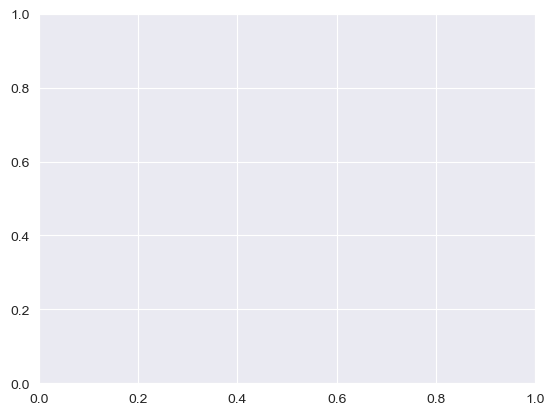

In [11]:
plt.scatter(X_train, y_train, color="blue", label="Actual")
plt.scatter(X_test, y_test, color="red", label="Predicted")
plt.title("DecisionTreeRegressor: Actual vs Predicted")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()